# Notebook Astromark AI

Questo notebook carica i dati dei ticket, li unisce e li preprocessa (utilizzando spaCy per tokenizzazione, lemmatizzazione e NER), costruisce la pipeline di ML, esegue la grid search, salva/carica il modello e infine fornisce un esempio di utilizzo del ticket service.

In [17]:
import sys
import os
import pandas as pd
from service.pipeline import (
    merge_dataframes, 
    dataframe_o3, 
    dataframe_gc, 
    PROCESSED_DATA_PATH, 
    parallel_process_texts, 
    ClassifierType, 
    get_model,
    logger
)

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

### Unione dei dati e preparazione delle variabili  
Questa cella unisce due DataFrame (`dataframe_o3` e `dataframe_gc`) utilizzando la funzione `merge_dataframes`, creando un dataset consolidato.

In [18]:
# Unione dei dati
merged_df = merge_dataframes(dataframe_o3, dataframe_gc)
X = merged_df['titolo_messaggio']
y = merged_df['categoria']
logger.info("Final merged dataset shape: %s", merged_df.shape)

[INFO] Merging dataframes...
[INFO] Eliminated 433 duplicate rows
[INFO] Final merged dataset shape: (5534, 2)


### Visualizzazione della Distribuzione delle Categorie  

Questa cella genera diversi grafici per analizzare la distribuzione delle categorie nel dataset `merged_df`, tra cui un grafico a barre, un grafico a torta, un grafico a barre con percentuali e un box plot della lunghezza del testo.  



Statistiche descrittive per categoria:
categoria
Segreteria    1235
Didattica     1123
Tecnico       1113
Accesso       1040
Profilo       1023
dtype: int64

Percentuali per categoria:
categoria
Segreteria    22.32
Didattica     20.29
Tecnico       20.11
Accesso       18.79
Profilo       18.49
Name: proportion, dtype: float64


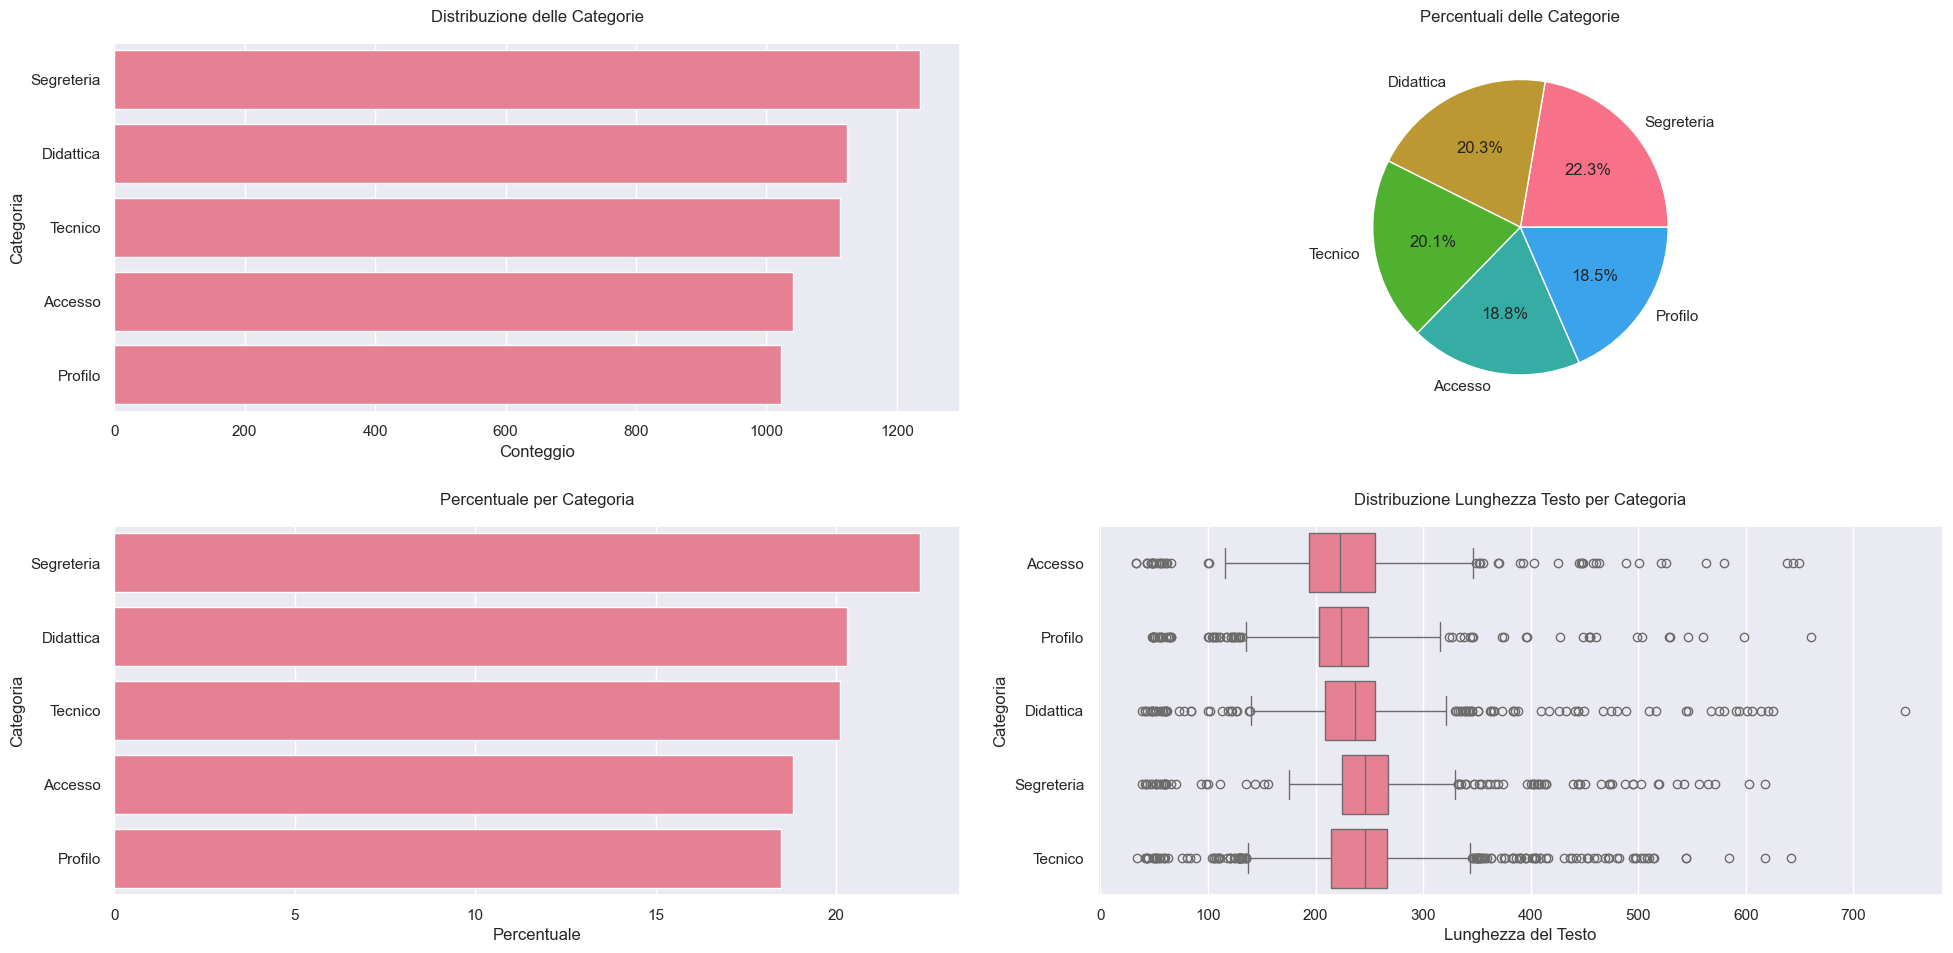

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni per una migliore visualizzazione
plt.style.use('default')  # Utilizziamo lo stile default di matplotlib
sns.set_theme()  # Applica il tema base di seaborn
sns.set_palette("husl")

# Creazione di una figura con più sottografici
fig = plt.figure(figsize=(20, 10))

# 1. Grafico a barre della distribuzione delle categorie
plt.subplot(2, 2, 1)
sns.countplot(data=merged_df, y='categoria', order=merged_df['categoria'].value_counts().index)
plt.title('Distribuzione delle Categorie', pad=15)
plt.xlabel('Conteggio')
plt.ylabel('Categoria')

# 2. Grafico a torta delle percentuali
plt.subplot(2, 2, 2)
category_counts = merged_df['categoria'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Percentuali delle Categorie', pad=15)

# 3. Grafico a barre orizzontale con percentuali
plt.subplot(2, 2, 3)
category_percentages = (merged_df['categoria'].value_counts(normalize=True) * 100)
sns.barplot(x=category_percentages.values, y=category_percentages.index)
plt.title('Percentuale per Categoria', pad=15)
plt.xlabel('Percentuale')
plt.ylabel('Categoria')

# 4. Box plot della lunghezza del testo per categoria
plt.subplot(2, 2, 4)
merged_df['text_length'] = merged_df['titolo_messaggio'].str.len()
sns.boxplot(data=merged_df, x='text_length', y='categoria')
plt.title('Distribuzione Lunghezza Testo per Categoria', pad=15)
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Categoria')

# Aggiusta il layout
plt.tight_layout(pad=2.0)

# Mostra statistiche descrittive
print("\nStatistiche descrittive per categoria:")
print(merged_df.groupby('categoria').size().sort_values(ascending=False))
print("\nPercentuali per categoria:")
print(category_percentages.round(2))

# Mostra il plot
plt.show()

### Caricamento o Preprocessing dei Dati  

Questa cella verifica se i dati preprocessati sono già disponibili e, in caso contrario, li elabora e li salva.  


In [19]:
# Carica o processa i dati preprocessati
if os.path.exists(PROCESSED_DATA_PATH):
    logger.info("Loading preprocessed data from '%s'...", PROCESSED_DATA_PATH)
    df = pd.read_csv(PROCESSED_DATA_PATH)
    X_processed = df["processed_text"]
else:
    logger.info("Preprocessed data not found, starting parallel preprocessing...")
    X_processed = parallel_process_texts(X, n_jobs=-1)
    logger.info("Saving preprocessed data to: %s", PROCESSED_DATA_PATH)
    X_processed_df = pd.DataFrame(X_processed, columns=["processed_text"])
    X_processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    logger.info("Preprocessing complete and cached.")

[INFO] Loading preprocessed data from 'C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\processed\X_processed.csv'...


## Fine della Pipeline

I dati sono stati caricati, preprocessati e il modello (ottenuto tramite Grid Search) è stato caricato o addestrato e salvato nella cartella `../data/trained`
#### Monitoraggio delle Risorse (CPU e Memoria) Durante l'Addestramento di Naive Bayes

Questa cella misura l'**andamento dell'uso della CPU e della memoria RAM** durante l'addestramento del classificatore **Naive Bayes**.  


[INFO] Measuring CPU & RAM usage while training naive_bayes...
[INFO] CPU & RAM usage measurement complete.
[INFO] Training finished in 5.24 seconds.
[INFO] Best parameters for naive_bayes: {'clf__alpha': 1.0, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1}


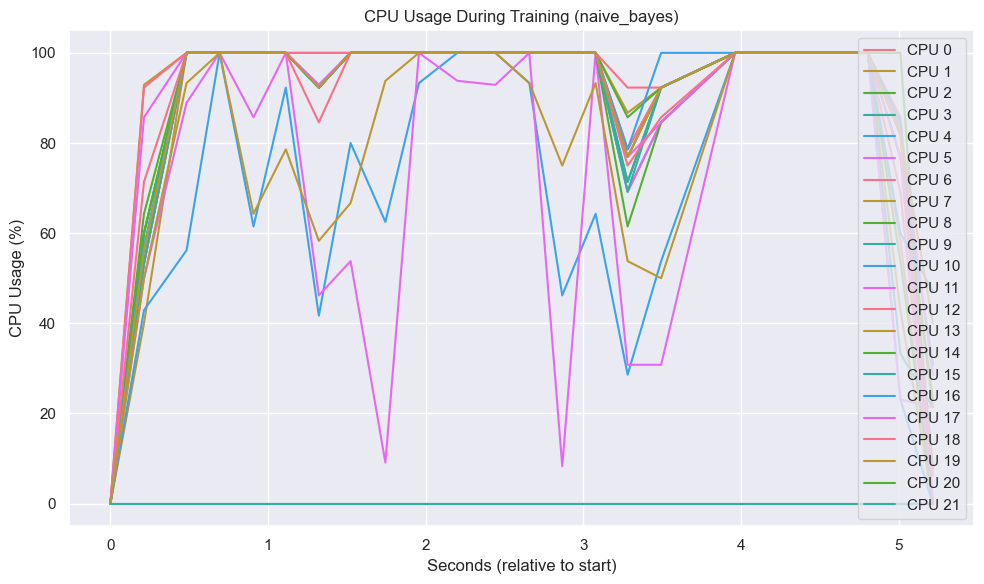

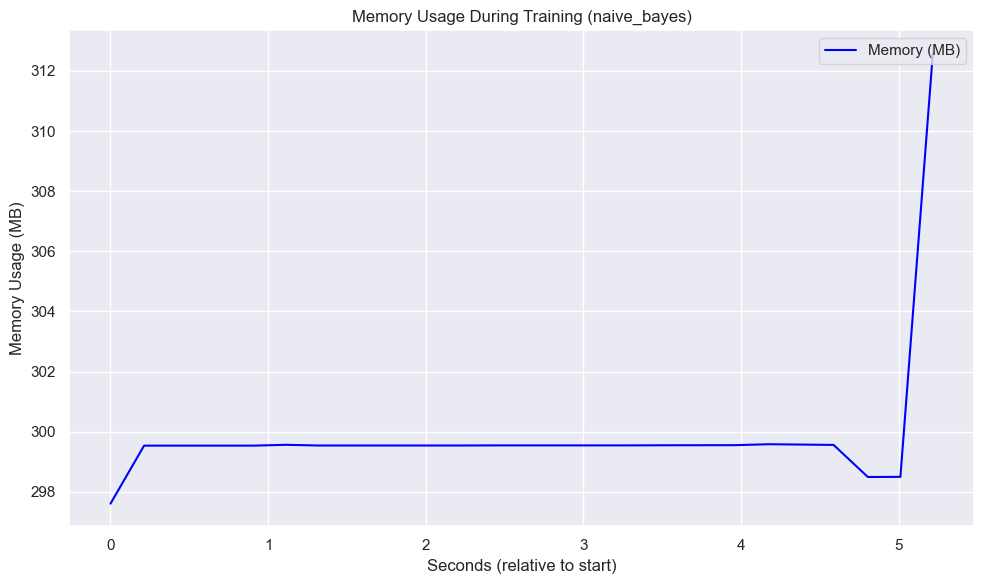

[INFO] Model saved to C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=3000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [5]:
from service.report_predict import evaluate_model_with_kfold
from service.pipeline import measure_pc_metrics_during_training
measure_pc_metrics_during_training(ClassifierType.NAIVE_BAYES, save_plot=False)

### Valutazione del Modello Naive Bayes con K-Fold Cross-Validation  

Questa cella esegue una **validazione incrociata (K-Fold cross-validation)** per il classificatore **Naive Bayes**, utilizzando il dataset `X_processed` per le caratteristiche e `y` per le etichette.  


[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


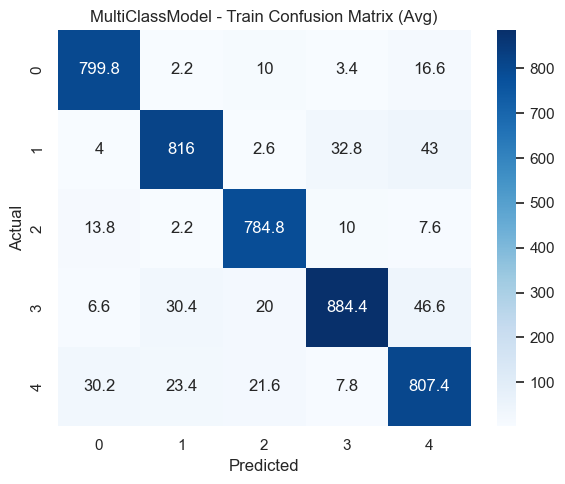

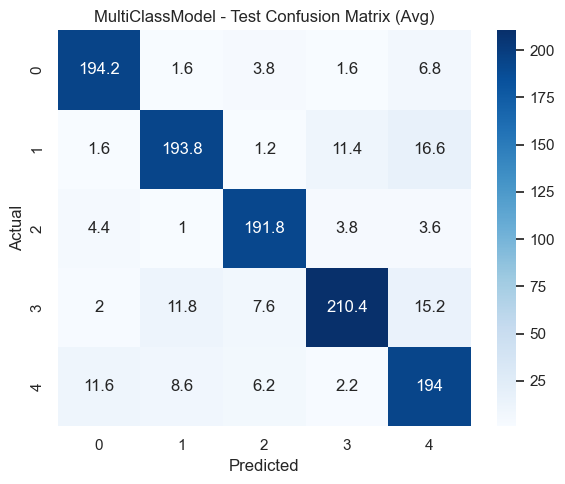

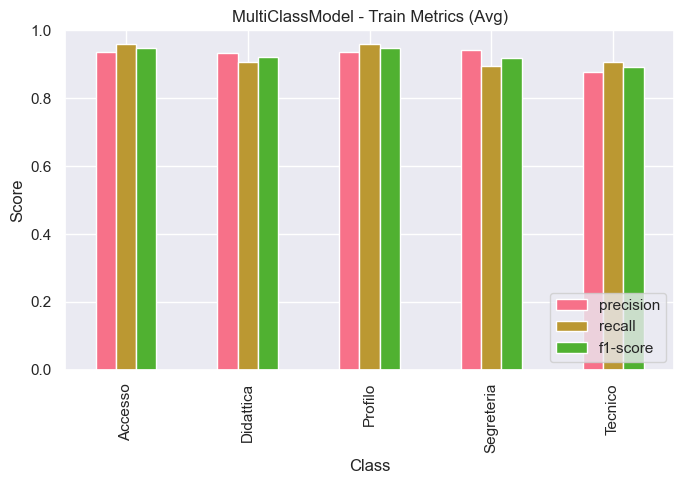

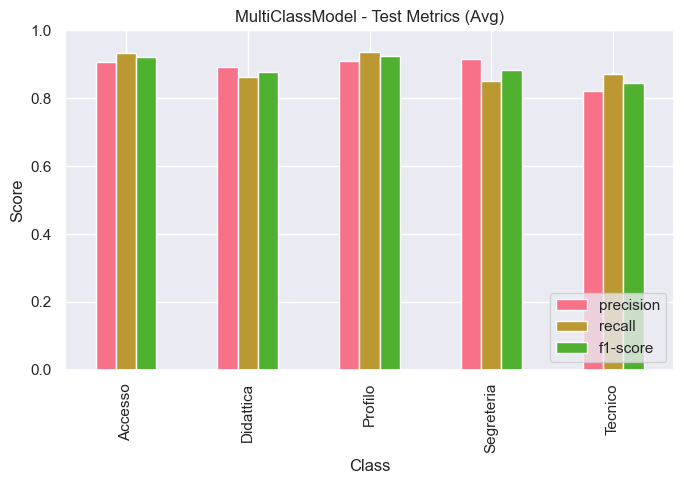

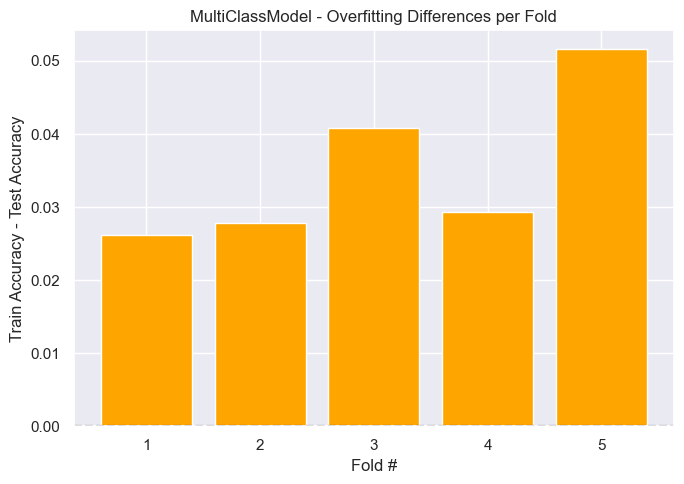

{'train': {'accuracy': 0.9243763887077918,
  'confusion_matrix': array([[799.8,   2.2,  10. ,   3.4,  16.6],
         [  4. , 816. ,   2.6,  32.8,  43. ],
         [ 13.8,   2.2, 784.8,  10. ,   7.6],
         [  6.6,  30.4,  20. , 884.4,  46.6],
         [ 30.2,  23.4,  21.6,   7.8, 807.4]]),
  'report_df':               precision    recall  f1-score      support
  Accesso        0.936107  0.961282  0.948519   832.000000
  Didattica      0.933407  0.908224  0.920636   898.400000
  Profilo        0.935467  0.958865  0.947006   818.400000
  Segreteria     0.942446  0.895142  0.918185   988.000000
  Tecnico        0.876518  0.906746  0.891359   890.400000
  accuracy       0.924376  0.924376  0.924376     0.924376
  macro avg      0.924789  0.926052  0.925141  4427.200000
  weighted avg   0.924868  0.924376  0.924332  4427.200000},
 'test': {'accuracy': 0.8892280098207854,
  'confusion_matrix': array([[194.2,   1.6,   3.8,   1.6,   6.8],
         [  1.6, 193.8,   1.2,  11.4,  16.6],
     

In [6]:
evaluate_model_with_kfold(get_model(ClassifierType.NAIVE_BAYES), X_processed, y)

### Monitoraggio delle Risorse (CPU e Memoria) Durante l'Addestramento di SVM

Questa cella misura l'**andamento dell'uso della CPU e della memoria RAM** durante l'addestramento del classificatore **SVM**.  


[INFO] Measuring CPU & RAM usage while training svm...
[INFO] CPU & RAM usage measurement complete.
[INFO] Training finished in 387.93 seconds.
[INFO] Best parameters for svm: {'clf__C': 2.0, 'svd__n_components': 150, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1}


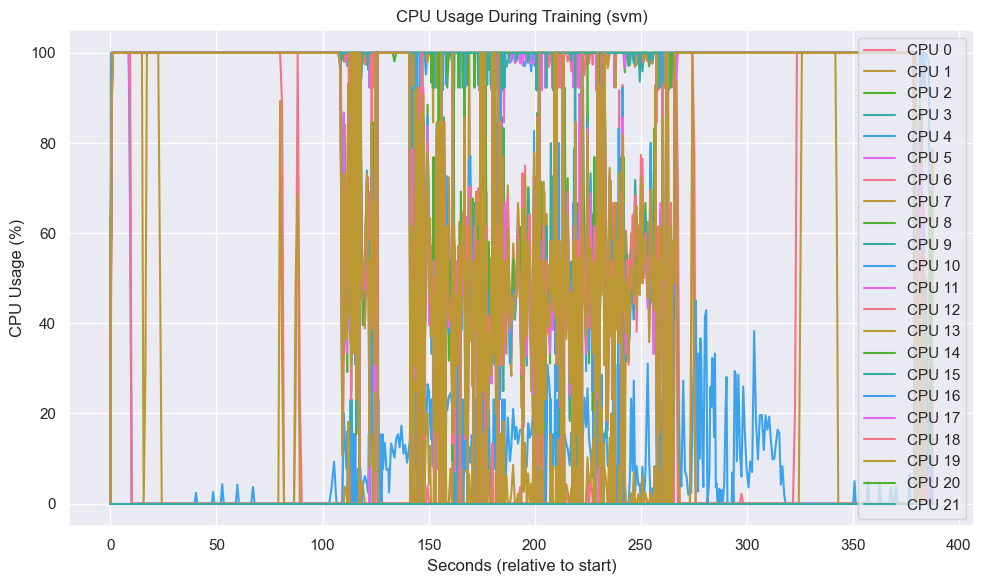

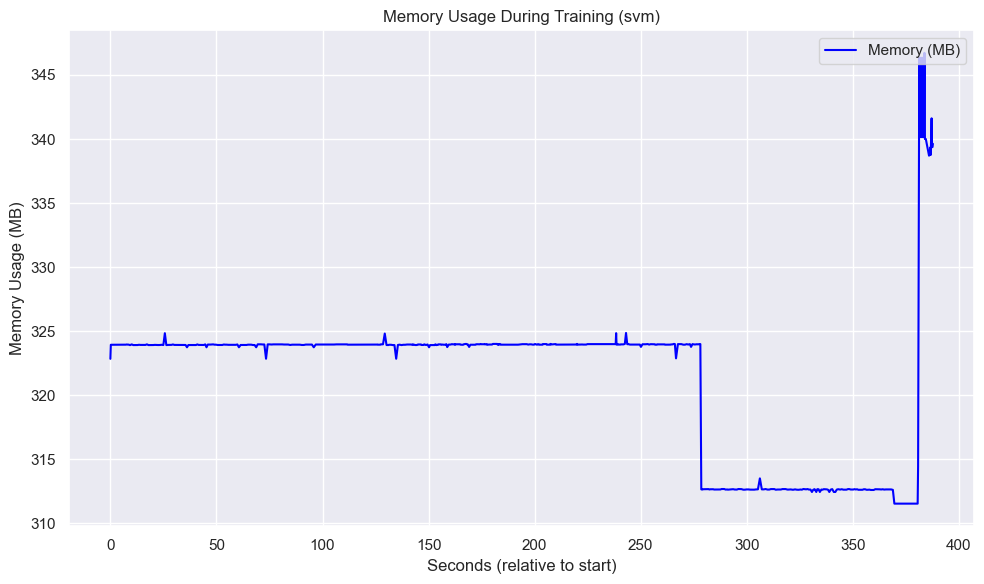

[INFO] Model saved to C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=3000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('svd', TruncatedSVD(n_components=150, random_state=42)),
                ('clf',
                 SVC(C=2.0, kernel='linear', probability=True,
                     random_state=42))])

In [7]:
measure_pc_metrics_during_training(ClassifierType.SVM, save_plot=False)

### Valutazione del Modello SVM con K-Fold Cross-Validation  

Questa cella esegue una **validazione incrociata (K-Fold cross-validation)** per il classificatore **SVM**, utilizzando il dataset `X_processed` per le caratteristiche e `y` per le etichette. 

[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


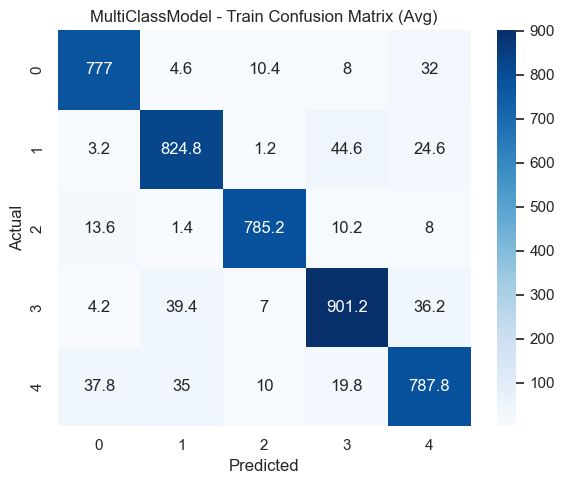

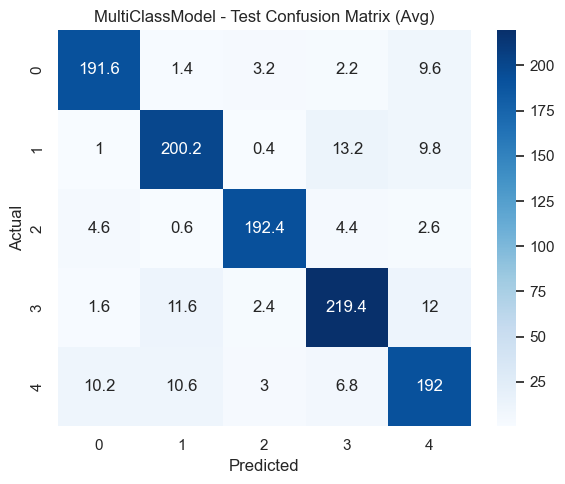

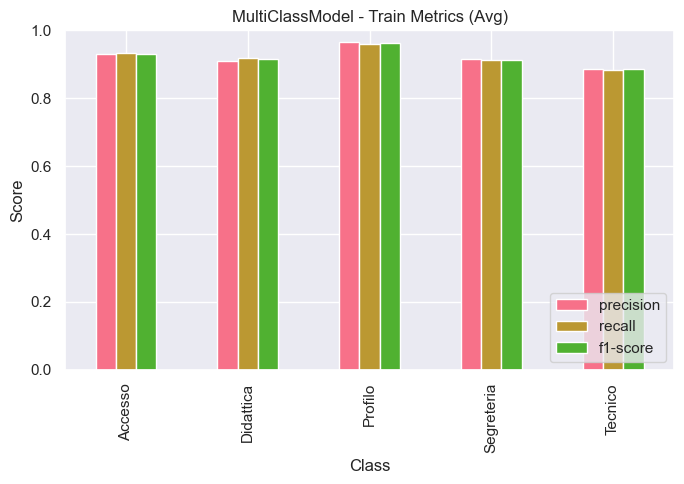

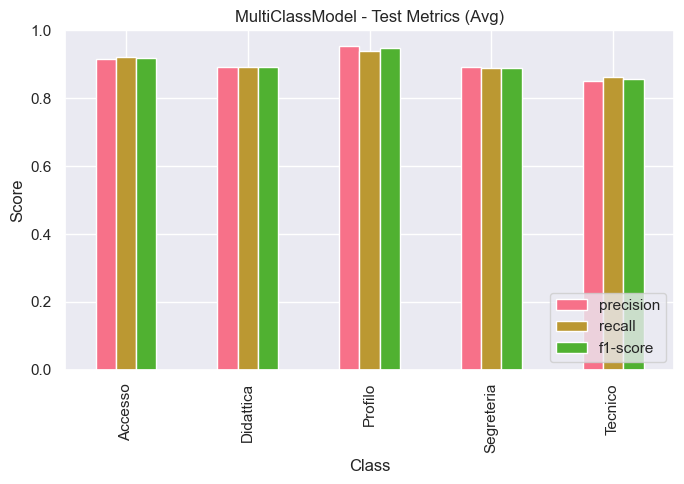

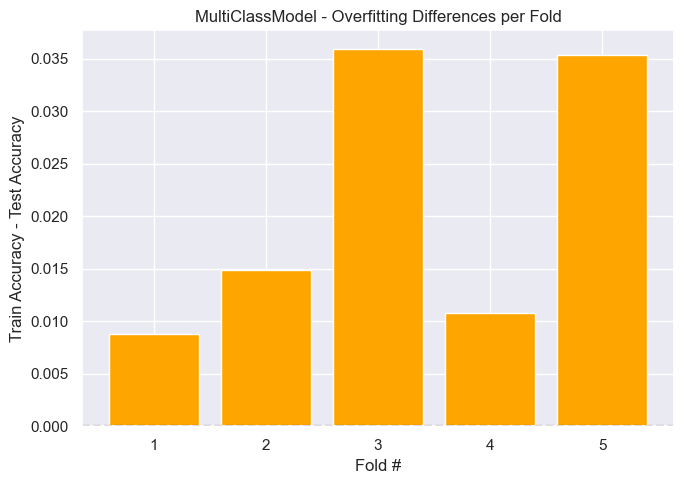

{'train': {'accuracy': 0.9206720116293852,
  'confusion_matrix': array([[777. ,   4.6,  10.4,   8. ,  32. ],
         [  3.2, 824.8,   1.2,  44.6,  24.6],
         [ 13.6,   1.4, 785.2,  10.2,   8. ],
         [  4.2,  39.4,   7. , 901.2,  36.2],
         [ 37.8,  35. ,  10. ,  19.8, 787.8]]),
  'report_df':               precision    recall  f1-score      support
  Accesso        0.929680  0.933889  0.931773   832.000000
  Didattica      0.911257  0.918037  0.914595   898.400000
  Profilo        0.964901  0.959373  0.962114   818.400000
  Segreteria     0.916069  0.912140  0.914081   988.000000
  Tecnico        0.886556  0.884816  0.885681   890.400000
  accuracy       0.920672  0.920672  0.920672     0.920672
  macro avg      0.921693  0.921651  0.921649  4427.200000
  weighted avg   0.920746  0.920672  0.920686  4427.200000},
 'test': {'accuracy': 0.8995283997445158,
  'confusion_matrix': array([[191.6,   1.4,   3.2,   2.2,   9.6],
         [  1. , 200.2,   0.4,  13.2,   9.8],
     

In [8]:
evaluate_model_with_kfold(get_model(ClassifierType.SVM), X_processed, y)

### Confronto tra Classificatori Naive Bayes e SVM con K-Fold Cross-Validation  

Questa cella esegue un **confronto tra due classificatori** (Naive Bayes e SVM) utilizzando la **validazione incrociata K-Fold** su tutto il dataset preprocessato. I risultati vengono calcolati per ogni fold e vengono comparati per determinare quale classificatore offre le migliori prestazioni.  


[INFO] Starting K-Fold comparison of Naive Bayes vs. SVM...
[INFO] Comparing Naive Bayes vs. SVM with 5-fold cross-validation...
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] Evaluating Naive Bayes with KFold...
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


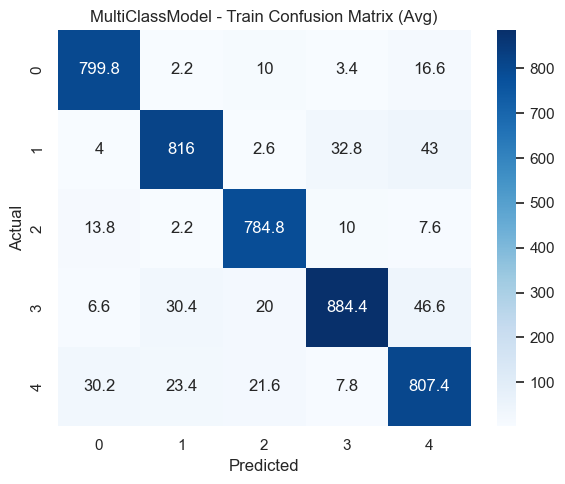

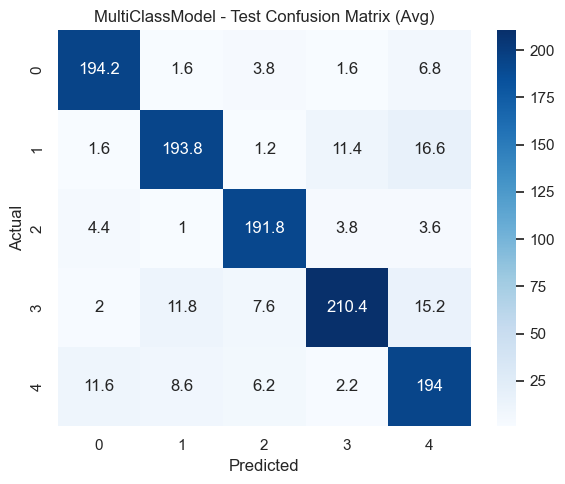

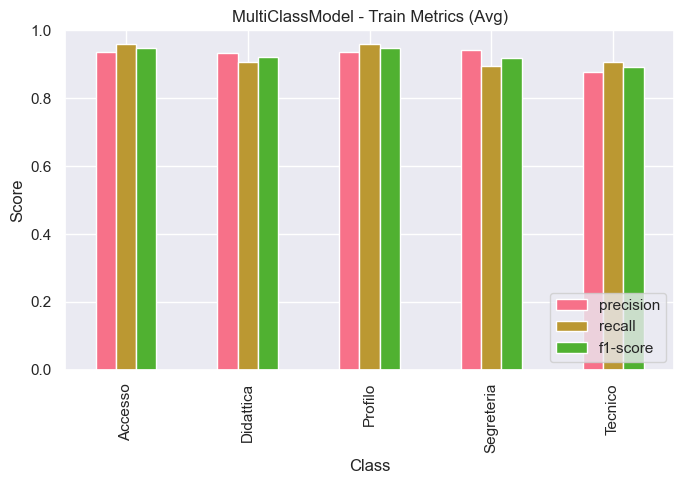

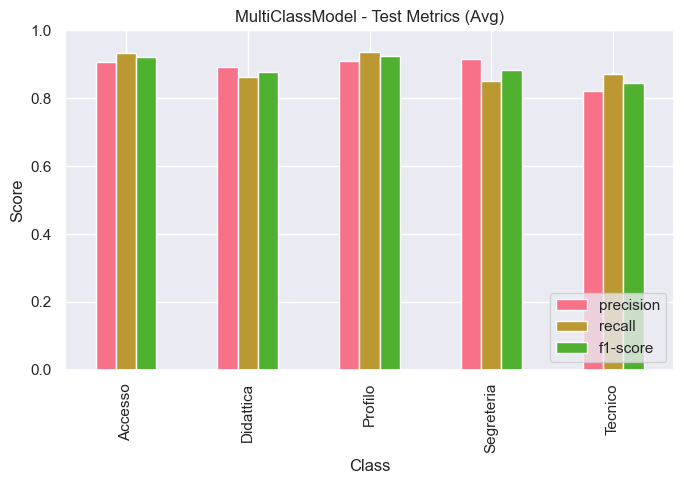

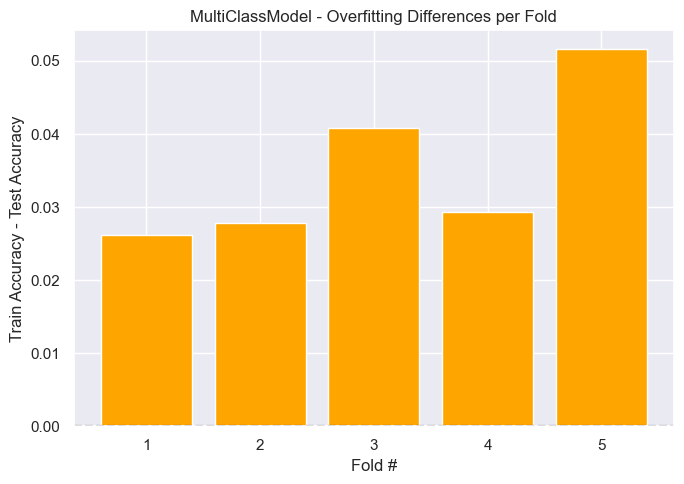

[INFO] Evaluating SVM with KFold...
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


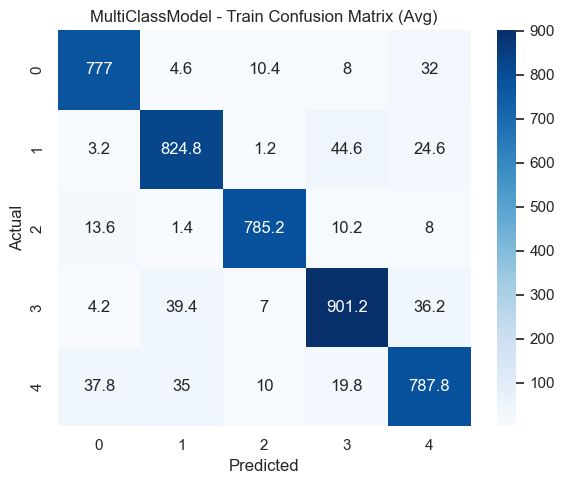

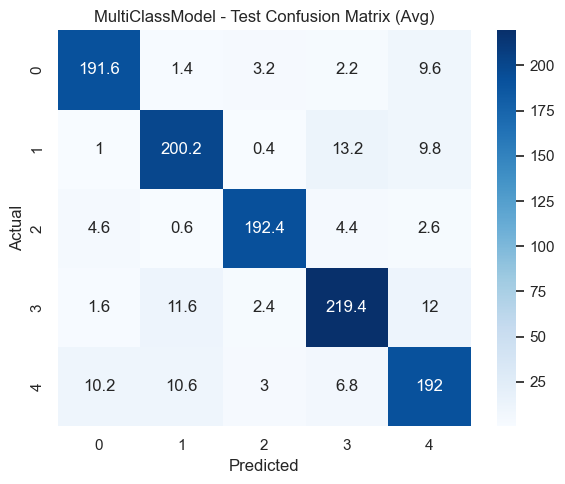

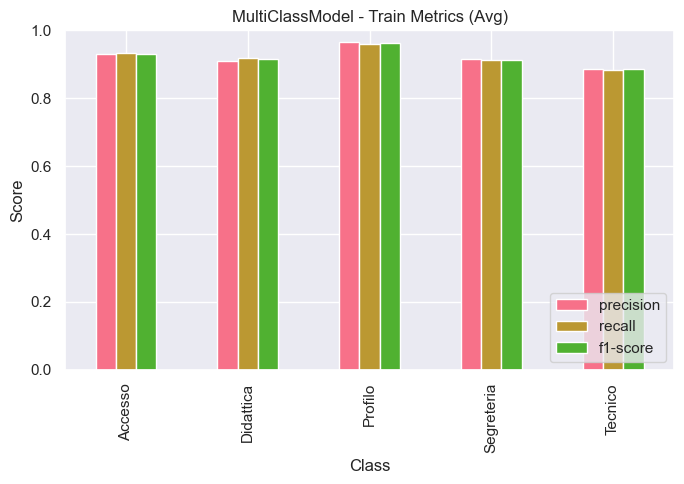

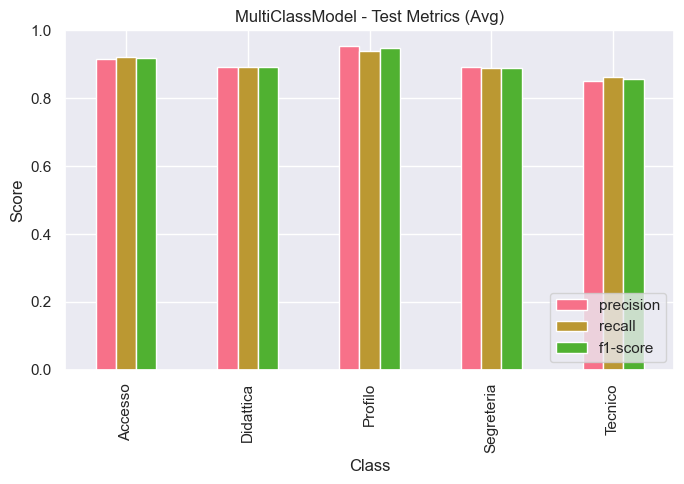

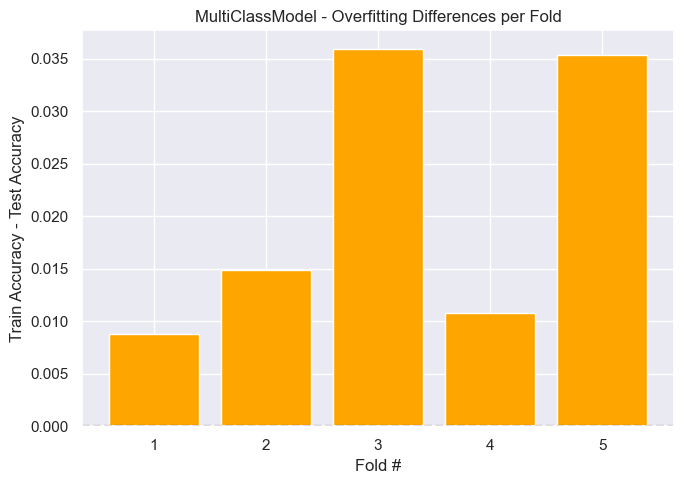

[INFO] KFold Comparison:
 Classifier  Train Accuracy  Test Accuracy  Overfitting (Train-Test)
Naive_Bayes        0.924376       0.889228                  0.035148
        SVM        0.920672       0.899528                  0.021144


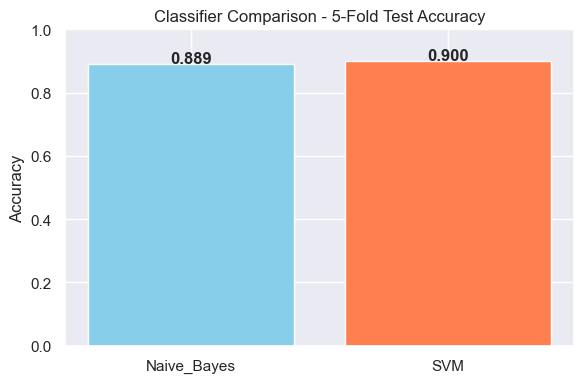

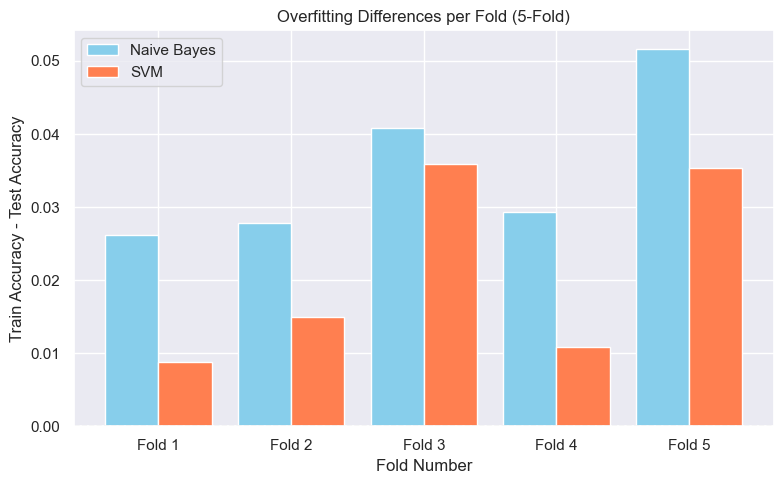

Comparison Results (Naive Bayes vs. SVM):


' Classifier  Train Accuracy  Test Accuracy  Overfitting (Train-Test)\nNaive_Bayes        0.924376       0.889228                  0.035148\n        SVM        0.920672       0.899528                  0.021144'

In [9]:
from service.report_predict import compare_classifiers_with_kfold

# Example usage of compare_classifiers_with_kfold
logger.info("Starting K-Fold comparison of Naive Bayes vs. SVM...")

# Use the entire preprocessed dataset
X_small, y_small = X_processed, y

# Compare the two classifiers with 5-fold CV,
# saving both the plots and the resulting DataFrame.
df_results = compare_classifiers_with_kfold(
    X_small,
    y_small,
    n_splits=5,
    shuffle=True,
    random_state=42,
    save_plots=False,  # True -> saves bar charts
    save_data=False  # True -> saves the final df_compare to CSV
)

print("Comparison Results (Naive Bayes vs. SVM):")
df_results.to_string(index=False)

## Fase di Controllo e Valutazione Completata - Passiamo all'Utilizzo del Dataset
Esempio di Funzione del Ticket Service: classificazione del Messaggio

In [10]:
# Esempio: Funzione per il Ticket Service
def ticket_service(title, message, classifier_type):
    get_model(classifier_type)
    full_text = f"{title} {message}".strip()
    if not full_text:
        return ["Nessun input fornito"]
    # Importa la funzione predict_category dal modulo report_predict
    from service.report_predict import predict_category
    predictions = predict_category(full_text, classifier_type)
    print("Predizioni:", predictions)
    return predictions

### Esempio di utilizzo con NAIVE BAYES

In [20]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.NAIVE_BAYES), columns=["Class", "Probability"])

[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] Predicting category for a new message...
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.


Predizioni: [('Tecnico', 0.8059766449335284), ('Accesso', 0.08502635595461643), ('Didattica', 0.03958791370193247)]


,Class,Probability
0,Tecnico,0.805977
1,Accesso,0.085026
2,Didattica,0.039588


### Esempio di utilizzo con SVM

In [21]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.SVM), columns=["Class", "Probability"])

[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] Predicting category for a new message...
[INFO] Loading saved model from C:\Users\Mario\PycharmProjects\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.


Predizioni: [('Tecnico', 0.9489869119020787), ('Accesso', 0.03288571236602546), ('Segreteria', 0.010986986618638542)]


,Class,Probability
0,Tecnico,0.948987
1,Accesso,0.032886
2,Segreteria,0.010987


## Analisi del Fenomeno di Hughes con TruncatedSVD

In questa sezione del notebook viene eseguita un'analisi per studiare l'effetto della variazione del numero di componenti del **TruncatedSVD** sulle performance del modello SVM. Utilizzando la funzione `plot_hughes_phenomenon_truncated_svd_fixed` importata dal modulo `service.report_predict`, il codice applica una validazione incrociata a 5 fold sul dataset ridotto (`X_small` e `y_small`).

In particolare, la funzione testa cinque specifici valori di componenti (100, 200, 500, 1000, 2000) e calcola l'accuratezza media sui dati di training e di test per ciascun valore. Questo grafico permette di osservare il fenomeno di Hughes, evidenziando come la scelta del numero di componenti possa influenzare la capacità del modello di generalizzare, aiutandoci a individuare un possibile punto ottimale in cui bilanciare la complessità del modello e le sue performance.


[INFO] Creating Hughes Phenomenon graph for fixed TruncatedSVD components: 100, 200, 500, 1000, 2000...


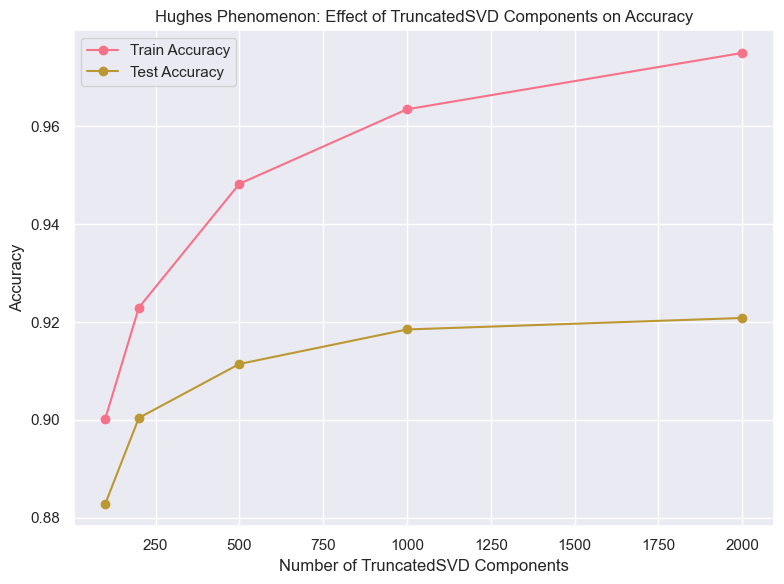

[INFO] Hughes Phenomenon graph created with components [100, 200, 500, 1000, 2000].


In [13]:
from service.report_predict import plot_hughes_phenomenon_truncated_svd_fixed
plot_hughes_phenomenon_truncated_svd_fixed(
    X_small,
    y_small,
    n_splits=5,
)

# Valutazione del Modello Word2Vec con Cross-Validation a 5 Fold

In questa sezione valutiamo un modello di classificazione testuale basato su Word2Vec, utilizzando una procedura di cross-validation a 5 fold con un classificatore SVM.

**Cosa fa il codice:**
- **Calcolo delle Metriche:** Vengono calcolate e stampate le metriche principali per ogni fold, quali:
  - Accuratezza (accuracy)
  - Matrice di Confusione
  - Classification Report (precision, recall, f1-score)
- **Aggregazione dei Risultati:** Al termine della validazione, le metriche dei vari fold vengono aggregate per fornire una panoramica complessiva delle performance del modello.

In [14]:
from service.word2vec_pipeline import evaluate_word2vec_model_kfold

evaluate_word2vec_model_kfold(ClassifierType.SVM, X, y)

[INFO] No saved Word2Vec model found for svm. Training a new one...


=== Fold 1 ===


[INFO] collecting all words and their counts
[INFO] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
[INFO] collected 4137 word types from a corpus of 103328 raw words and 5534 sentences
[INFO] Creating a fresh vocabulary
[INFO] Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 4137 unique words (100.00% of original 4137, drops 0)', 'datetime': '2025-02-10T03:15:45.613145', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'prepare_vocab'}
[INFO] Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 103328 word corpus (100.00% of original 103328, drops 0)', 'datetime': '2025-02-10T03:15:45.615145', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'prepare_vocab'}
[INFO] deleting the raw counts dictionary of 4137 items
[INFO

Train Accuracy: 0.7021
Test Accuracy:  0.6956
Confusion Matrix:
 [[146   2  13   9  31]
 [  6 155   0  39  28]
 [ 12   8 190  11  11]
 [ 13  34   5 142  41]
 [ 18  26   4  26 137]]
Classification Report:
  Accesso: {'precision': 0.7487179487179487, 'recall': 0.7263681592039801, 'f1-score': 0.7373737373737373, 'support': 201.0}
  Didattica: {'precision': 0.6888888888888889, 'recall': 0.6798245614035088, 'f1-score': 0.6843267108167771, 'support': 228.0}
  Profilo: {'precision': 0.8962264150943396, 'recall': 0.8189655172413793, 'f1-score': 0.8558558558558559, 'support': 232.0}
  Segreteria: {'precision': 0.6255506607929515, 'recall': 0.6042553191489362, 'f1-score': 0.6147186147186147, 'support': 235.0}
  Tecnico: {'precision': 0.5524193548387096, 'recall': 0.6492890995260664, 'f1-score': 0.5969498910675382, 'support': 211.0}
  accuracy: 0.6955736224028907
  macro avg: {'precision': 0.7023606536665676, 'recall': 0.6957405313047741, 'f1-score': 0.6978449619665046, 'support': 1107.0}
  weigh

[INFO] EPOCH 0: training on 150253 raw words (119004 effective words) took 0.1s, 2131500 effective words/s
[INFO] EPOCH 1: training on 150253 raw words (119286 effective words) took 0.1s, 2370812 effective words/s
[INFO] EPOCH 2: training on 150253 raw words (119116 effective words) took 0.1s, 2067731 effective words/s
[INFO] EPOCH 3: training on 150253 raw words (119130 effective words) took 0.1s, 2189769 effective words/s
[INFO] EPOCH 4: training on 150253 raw words (118878 effective words) took 0.1s, 2049419 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 751265 raw words (595414 effective words) took 0.3s, 1737753 effective words/s', 'datetime': '2025-02-10T03:15:50.710213', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11364, vector_size=50, alpha=0.025>', 'datetime': '2025-02

Train Accuracy: 0.6980
Test Accuracy:  0.7109
Confusion Matrix:
 [[171   1   8   8  24]
 [  7 142   0  29  49]
 [ 10   8 158   2  11]
 [ 10  29   6 159  42]
 [ 30  20   8  18 157]]
Classification Report:
  Accesso: {'precision': 0.75, 'recall': 0.8066037735849056, 'f1-score': 0.7772727272727272, 'support': 212.0}
  Didattica: {'precision': 0.71, 'recall': 0.6255506607929515, 'f1-score': 0.6651053864168618, 'support': 227.0}
  Profilo: {'precision': 0.8777777777777778, 'recall': 0.8359788359788359, 'f1-score': 0.8563685636856369, 'support': 189.0}
  Segreteria: {'precision': 0.7361111111111112, 'recall': 0.6463414634146342, 'f1-score': 0.6883116883116883, 'support': 246.0}
  Tecnico: {'precision': 0.5547703180212014, 'recall': 0.6738197424892703, 'f1-score': 0.6085271317829457, 'support': 233.0}
  accuracy: 0.7109304426377597
  macro avg: {'precision': 0.7257318413820181, 'recall': 0.7176588952521196, 'f1-score': 0.719117099493972, 'support': 1107.0}
  weighted avg: {'precision': 0.7194

[INFO] EPOCH 1: training on 150361 raw words (119134 effective words) took 0.1s, 2353097 effective words/s
[INFO] EPOCH 2: training on 150361 raw words (119158 effective words) took 0.0s, 2424305 effective words/s
[INFO] EPOCH 3: training on 150361 raw words (119239 effective words) took 0.0s, 2442902 effective words/s
[INFO] EPOCH 4: training on 150361 raw words (119144 effective words) took 0.0s, 2506063 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 751805 raw words (595851 effective words) took 0.3s, 2037468 effective words/s', 'datetime': '2025-02-10T03:15:53.047189', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11306, vector_size=50, alpha=0.025>', 'datetime': '2025-02-10T03:15:53.048078', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [M

Train Accuracy: 0.7165
Test Accuracy:  0.6757
Confusion Matrix:
 [[156   2   6  12  31]
 [ 12 131   3  33  46]
 [ 17   7 162   5  12]
 [ 11  33   6 154  31]
 [ 36  25   5  26 145]]
Classification Report:
  Accesso: {'precision': 0.6724137931034483, 'recall': 0.7536231884057971, 'f1-score': 0.7107061503416856, 'support': 207.0}
  Didattica: {'precision': 0.6616161616161617, 'recall': 0.5822222222222222, 'f1-score': 0.6193853427895981, 'support': 225.0}
  Profilo: {'precision': 0.8901098901098901, 'recall': 0.7980295566502463, 'f1-score': 0.8415584415584415, 'support': 203.0}
  Segreteria: {'precision': 0.6695652173913044, 'recall': 0.6553191489361702, 'f1-score': 0.6623655913978495, 'support': 235.0}
  Tecnico: {'precision': 0.5471698113207547, 'recall': 0.6118143459915611, 'f1-score': 0.5776892430278885, 'support': 237.0}
  accuracy: 0.6757000903342367
  macro avg: {'precision': 0.6881749747083118, 'recall': 0.6802016924411993, 'f1-score': 0.6823409538230926, 'support': 1107.0}
  weigh

[INFO] EPOCH 0: training on 150251 raw words (119177 effective words) took 0.0s, 2764255 effective words/s
[INFO] EPOCH 1: training on 150251 raw words (118864 effective words) took 0.1s, 2313812 effective words/s
[INFO] EPOCH 2: training on 150251 raw words (119058 effective words) took 0.0s, 2438933 effective words/s
[INFO] EPOCH 3: training on 150251 raw words (118970 effective words) took 0.1s, 2103121 effective words/s
[INFO] EPOCH 4: training on 150251 raw words (118943 effective words) took 0.1s, 2107274 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 751255 raw words (595012 effective words) took 0.3s, 1891392 effective words/s', 'datetime': '2025-02-10T03:15:55.209487', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11403, vector_size=50, alpha=0.025>', 'datetime': '2025-02

Train Accuracy: 0.6939
Test Accuracy:  0.7010
Confusion Matrix:
 [[164   4  15   8  25]
 [ 10 149   5  40  30]
 [ 19   6 163   5  10]
 [  5  29   3 176  36]
 [ 34  19   7  21 124]]
Classification Report:
  Accesso: {'precision': 0.7068965517241379, 'recall': 0.7592592592592593, 'f1-score': 0.7321428571428571, 'support': 216.0}
  Didattica: {'precision': 0.7198067632850241, 'recall': 0.6367521367521367, 'f1-score': 0.6757369614512472, 'support': 234.0}
  Profilo: {'precision': 0.844559585492228, 'recall': 0.8029556650246306, 'f1-score': 0.8232323232323232, 'support': 203.0}
  Segreteria: {'precision': 0.704, 'recall': 0.7068273092369478, 'f1-score': 0.7054108216432866, 'support': 249.0}
  Tecnico: {'precision': 0.5511111111111111, 'recall': 0.6048780487804878, 'f1-score': 0.5767441860465117, 'support': 205.0}
  accuracy: 0.7009936766034327
  macro avg: {'precision': 0.7052748023225002, 'recall': 0.7021344838106924, 'f1-score': 0.7026534299032451, 'support': 1107.0}
  weighted avg: {'pre

[INFO] EPOCH 1: training on 150938 raw words (119701 effective words) took 0.1s, 2327975 effective words/s
[INFO] EPOCH 2: training on 150938 raw words (119495 effective words) took 0.0s, 2617846 effective words/s
[INFO] EPOCH 3: training on 150938 raw words (119778 effective words) took 0.0s, 2607889 effective words/s
[INFO] EPOCH 4: training on 150938 raw words (119772 effective words) took 0.0s, 2504491 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 754690 raw words (598460 effective words) took 0.3s, 1956376 effective words/s', 'datetime': '2025-02-10T03:15:57.528105', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11357, vector_size=50, alpha=0.025>', 'datetime': '2025-02-10T03:15:57.529264', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [M

Train Accuracy: 0.7055
Test Accuracy:  0.7061
Confusion Matrix:
 [[155   1  14   4  30]
 [  3 139   1  24  42]
 [  9   9 163   4  11]
 [ 10  33   4 178  45]
 [ 26  25   6  24 146]]
Classification Report:
  Accesso: {'precision': 0.7635467980295566, 'recall': 0.7598039215686274, 'f1-score': 0.7616707616707616, 'support': 204.0}
  Didattica: {'precision': 0.6714975845410628, 'recall': 0.6650717703349283, 'f1-score': 0.6682692307692307, 'support': 209.0}
  Profilo: {'precision': 0.8670212765957447, 'recall': 0.8316326530612245, 'f1-score': 0.8489583333333334, 'support': 196.0}
  Segreteria: {'precision': 0.7606837606837606, 'recall': 0.6592592592592592, 'f1-score': 0.7063492063492064, 'support': 270.0}
  Tecnico: {'precision': 0.5328467153284672, 'recall': 0.6431718061674009, 'f1-score': 0.5828343313373253, 'support': 227.0}
  accuracy: 0.7061482820976492
  macro avg: {'precision': 0.7191192270357184, 'recall': 0.7117878820782881, 'f1-score': 0.7136163726919715, 'support': 1106.0}
  weigh

{'train': {'accuracy': 0.7031983053811414,
  'confusion_matrix': array([[158.4,   2. ,  11.2,   8.2,  28.2],
         [  7.6, 143.2,   1.8,  33. ,  39. ],
         [ 13.4,   7.6, 167.2,   5.4,  11. ],
         [  9.8,  31.6,   4.8, 161.8,  39. ],
         [ 28.8,  23. ,   6. ,  23. , 141.8]]),
  'classification_report':               precision    recall  f1-score      support
  Accesso        0.728315  0.761132  0.743833   208.000000
  Didattica      0.690362  0.637884  0.662565   224.600000
  Profilo        0.875139  0.817512  0.845195   204.600000
  Segreteria     0.699182  0.654400  0.675431   247.000000
  Tecnico        0.547663  0.636595  0.588549   222.600000
  accuracy       0.697869  0.697869  0.697869     0.697869
  macro avg      0.708132  0.701505  0.703115  1106.800000
  weighted avg   0.705543  0.697869  0.699956  1106.800000},
 'test': {'accuracy': 0.6978692228151939}}